In [7]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import sys
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import noisereduce as nr
import numpy as np
import opensmile
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torchaudio
from ipywidgets import GridspecLayout, Output
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from tqdm.auto import tqdm

sys.path.append("..")
from IPython.display import Audio, display

from GSSP_utils.data_filtering import get_valid_audio_mask
from GSSP_utils.path_conf import (
    interim_speech_data_dir,
    loc_data_dir,
    speech_data_session_dir,
)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
sns.set_context("talk")
sns.set_style("whitegrid")

# https://pytorch.org/audio/stable/backend.html#module-torchaudio.backend
torchaudio.get_audio_backend()

import torch
from speechbrain.pretrained import VAD

from GSSP_utils.speech_analysis import whole_duration_image


In [4]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

# load the model
VAD_model = VAD.from_hparams(
    source="speechbrain/vad-crdnn-libriparty", savedir=".vad_model"
)

smile_lld = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    # feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
feat_cols = ["F0semitoneFrom27.5Hz_sma3nz", "jitterLocal_sma3nz"]
# feat_cols = ["F0final_sma", "voicingFinalUnclipped_sma"]

# Analyze the audio quality 

This notebook applies the `Analyze` step of the speech data processing pipeline.

![](https://cdn.discordapp.com/attachments/372491075153166338/1049274916106665985/2022-12-01_15-08-45.jpeg)

## On a user level

In [9]:
from GSSP_utils.speech_analysis import analyze_audio_quality


age-sex: 30 - female		education: ho		device: pc-mic
#Radboud: 15   -   #Pisces: 15   -   #Marloes: 7  -  SR=48000Hz


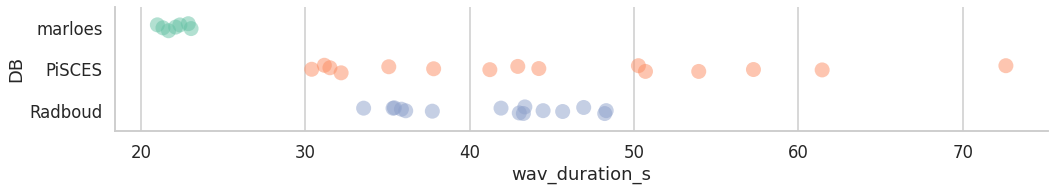

============================== marloes ==============================
Playing from 5 to 10 seconds  |orig norm| 16khz norm |


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

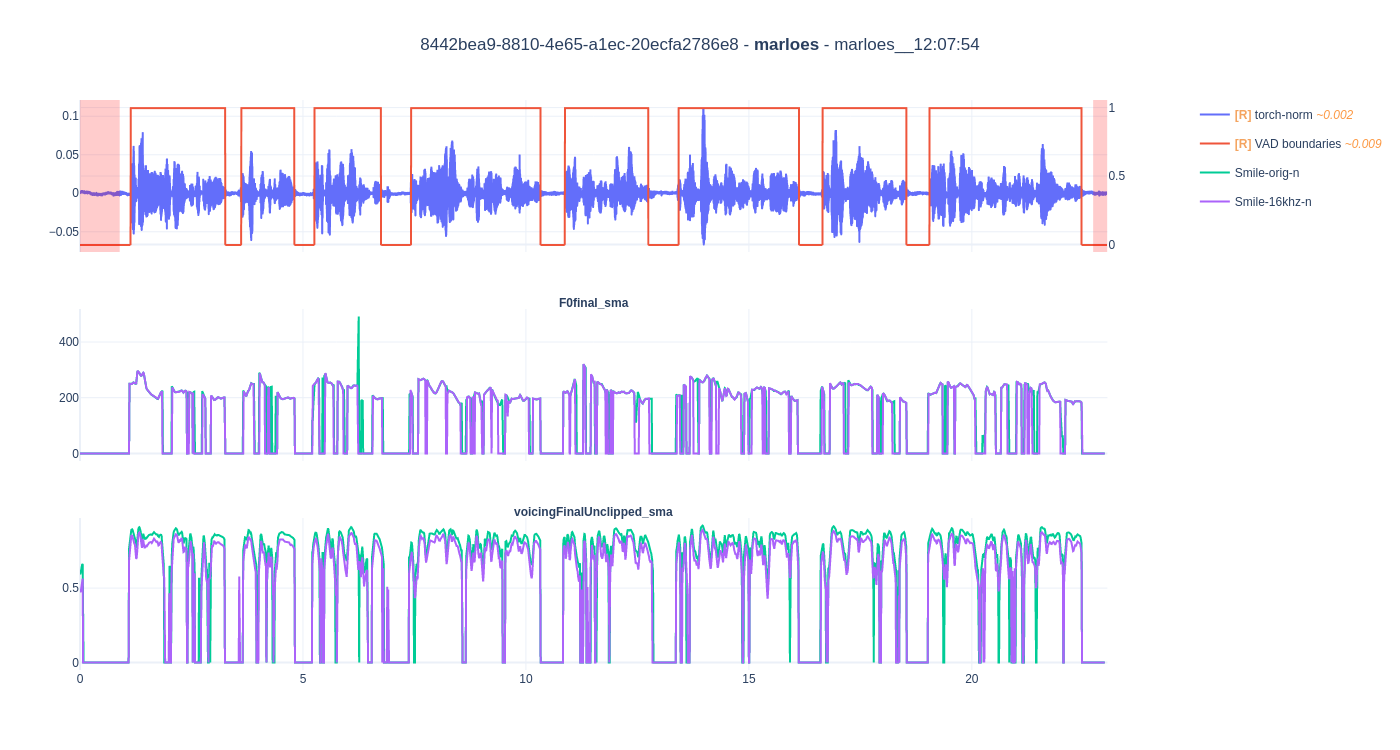

============================== Radboud ==============================
Playing from 5 to 10 seconds  |orig norm| 16khz norm |


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

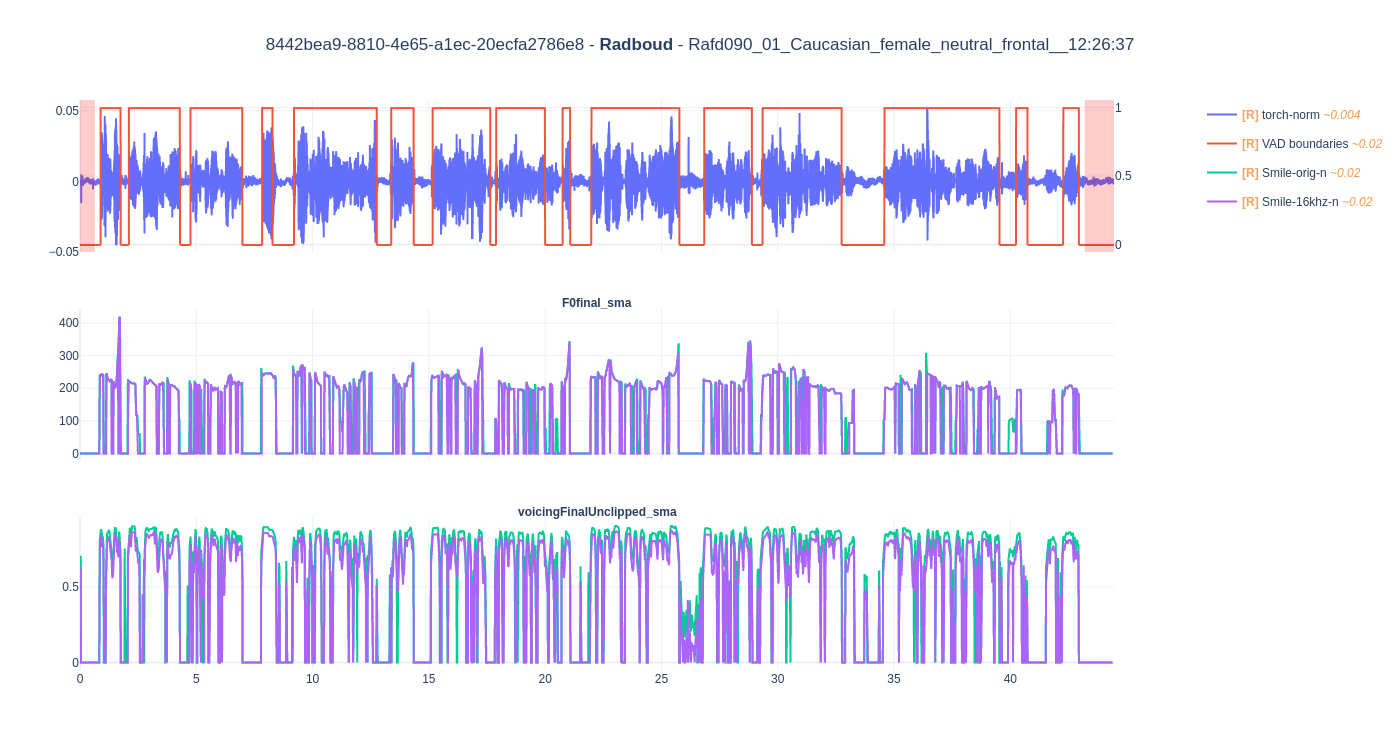

,norm_16Khz__marloes_1_1,norm_16Khz__Radboud_10_24
F0final_sma,0.846000,0.865000
voicingFinalUnclipped_sma,0.955000,0.958000
jitterLocal_sma,0.416000,0.542000
jitterDDP_sma,0.204000,0.497000
shimmerLocal_sma,0.711000,0.700000
logHNR_sma,0.894000,0.891000
audspec_lengthL1norm_sma,1.000000,1.000000
audspecRasta_lengthL1norm_sma,1.000000,1.000000
pcm_RMSenergy_sma,0.989000,0.986000
pcm_zcr_sma,0.961000,0.963000


In [5]:
row = 43
case = 1

if case == 1:  # Compare
    smile_lld = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    feat_cols = [
        "F0final_sma",
        "voicingFinalUnclipped_sma",
    ]  # emobase
    numb_dict = {"n_marloes": 1, "n_radboud": 1, "n_pisces": 0}
else:  # if case == 1:  # Gemaps
    smile_lld = opensmile.Smile(
        feature_set=opensmile.FeatureSet.GeMAPSv01b,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    feat_cols = ["F0semitoneFrom27.5Hz_sma3nz", "jitterLocal_sma3nz"]  # gemaps
    numb_dict = {"n_marloes": 0, "n_radboud": 0, "n_pisces": 2}

analyze_audio_quality(
    df_session=df_session,
    ID=np.unique(df_session.ID)[row - 2],
    **numb_dict,
    plot=True,
    plot_type="png",
    audio=True,
    norm_audio=True,
    vad=True,
    show_wav_features=False,
    noise_reduction=False,
    audio_begin_s=5,
    audio_end_s=10,
    smile_lld=smile_lld,
    feat_cols=feat_cols,
)


## After mnual analysis: On an utterance level

In [14]:
from GSSP_utils.speech_analysis import analyze_utterance
from GSSP_utils.data_filtering import _silent_recording_mask
from GSSP_utils.data_filtering import _noisy_recording_mask

df_silent_sessions = df_session[_silent_recording_mask(df_session)]



In [18]:
# Load the outcome of the manual analysis script
df_analysis = pd.read_csv(loc_data_dir.joinpath("GSSP_manual_analysis.tsv"), sep="\t")
df_analysis.Retain.value_counts()


YES                                  79
UNSURE                                8
NO                                    1
YES (if we apply duration filter)     1
Name: Retain, dtype: int64

In [12]:
# set the pandas columns display width to nan
pd.set_option("display.max_colwidth", None)
df_analysis[df_analysis.Retain.str.upper() != "YES"]


,ID,Retain,Retain after parsing,Use NR,NR version,Remarks,Quality
1,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,UNSURE,NO,Maybe,v1,Zeker geen native nederlands spreker - check with mitchel. Ook een klein beetje een visbokaal-effect / lage kwaliteit microfoon,NaN
11,28d01050-e4e0-4115-a5e9-09c8cb917fb0,UNSURE,NO,NO,/,"Weird accent, audio features do look rather okay when they are extracted, but more often than not, they are not extracted.",NaN
22,3a8266c9-7087-45fe-98e4-6c9c001c0050,UNSURE,UNSURE,No,/,Low quality user data Opensmile features lijken wat raar.,Neig mss eerder naar een yes bij deze participant
24,42c842a5-7051-44c3-af42-cf824fded959,NO,NO,/,/,Really Low quality user data,"Heeft enkele files die geen jitter zijn, maar lijkt me niet de moeite waard om hem om die reden de includerne"
55,a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f,YES (if we apply duration filter),YES,NO,/,Too muchs hort sessions Audio and opensmile features are good however,Very good
59,aeacc3a4-754e-4cd3-9ce7-62a41147d637,UNSURE,YES,NO,/,Soms veel piekjes op de F0 LLD Is volgens mij de sissende s,okay
74,d0b8f0d0-c38d-4594-b97c-ac87cafc21ab,UNSURE,UNSURE,NO,/,Lage audio kwaliteit. Visbokaal geluid. To check with mitchel,okay
75,d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a,UNSURE,YES,NO,/,"Low quality user data. Sommige files hebben goede kwaliteit, andere veel mindere. conclusion: manually check each file",okay
82,f2ad7300-0c96-4f72-9b84-8913fd54f34c,UNSURE,UNSURE,NO,/,"Heel veel achtegrondgeluid. Opensmile + VAD lijkt last te hebben om de features goed te kunnen extraheren. Degene die ge-extraheerd worden, maken wel sense. Geen F0 piekjes bv.",fair
84,f46c79e9-7c35-4bd4-b384-078aeae84af7,UNSURE,UNSURE,NO,/,"Heel veel achtegrondgeluid. Opensmile + VAD lijkt last te hebben om de features goed te kunnen extraheren. Degene die ge-extraheerd worden, maken wel sense. Geen F0 piekjes bv.",okay


In [9]:
# analyze_utterance(
#     # Low quality session -> a lot of noise
#     #   => opensmile cannot qualitatively extract features
#     utterance=df_session[
#         (df_session.ID == "8f42a931-7bd1-4536-bec3-a5f24da3c61f")
#         # (df_session.ID == "aeacc3a4-754e-4cd3-9ce7-62a41147d637")
#         & (df_session.time_str == "19:58:11")
#     ]
#     .sample(1)
#     .iloc[0],
#     plot=True,
#     audio=True,
#     norm_audio=False,
#     vad=True,
#     noise_reduction=False,
#     audio_begin_s=0,
#     audio_end_s=25,
#     show_corr=False,
#     noise_factor=0,
#     plot_type="dash",
# )


age-sex: 29 - male		education: unif		device: pc-mic
range -0.46 0.6 1.06
range [-0.15  0.23]


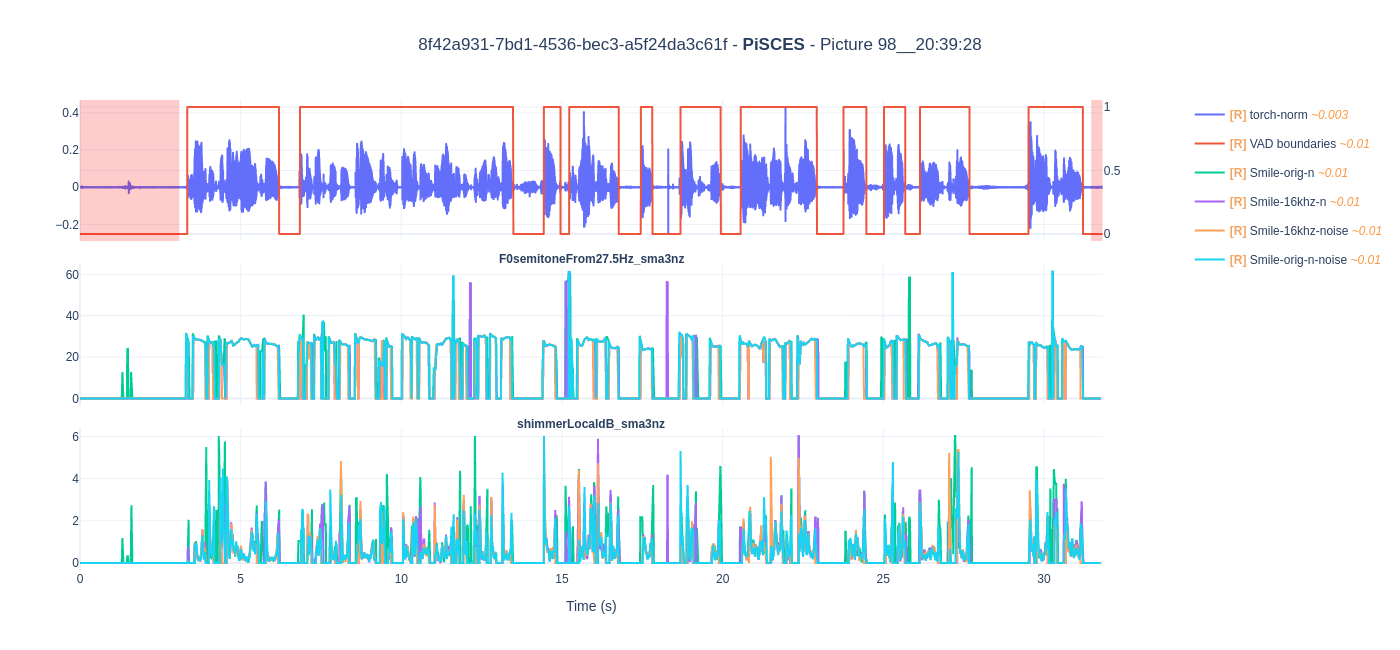

age-sex: 29 - male		education: unif		device: pc-mic
range -0.32 0.44 0.76
range [-0.14  0.2 ]


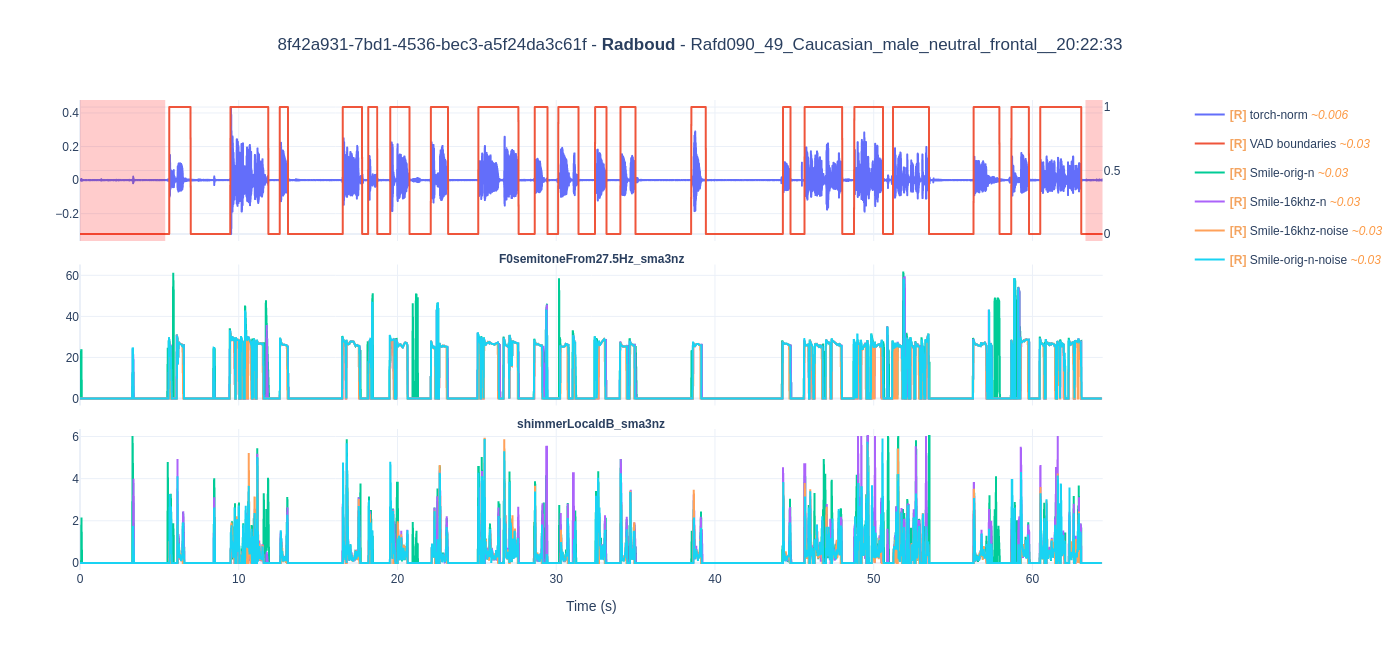

In [13]:
for _, utt in df_session[
        (df_session.ID == "8f42a931-7bd1-4536-bec3-a5f24da3c61f")
        # (df_session.ID == "aeacc3a4-754e-4cd3-9ce7-62a41147d637")
        # (df_session.ID == "f2ad7300-0c96-4f72-9b84-8913fd54f34c")
        # (df_session.ID == "3a8266c9-7087-45fe-98e4-6c9c001c0050")
        # & (df_session.time_str == "20:07:29")
    ].sample(2).iterrows():
    analyze_utterance(
        # Low quality session -> a lot of noise
        #   => opensmile cannot qualitatively extract features
        utterance=utt,
        plot=True,
        audio=False,
        norm_audio=False,
        vad=True,
        noise_reduction=False,
        audio_begin_s=0,
        audio_end_s=25,
        show_corr=False,
        plot_type="png",
        noise_factor=(0.5 / 30),
    )


In [16]:
df_session[_noisy_recording_mask(df_session)].sample(3)


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,wav_timestamp,DB,arousal,valence,DB_no,session_no,pic_no
424,20,so,male,2022-06-27 14:25:55.558194+02:00,28d01050-e4e0-4115-a5e9-09c8cb917fb0,7,15,15,pc-mic,60b6567e8882e6423a254d00,Picture 56,15:04:29,7143468,48000,74.41,2022-06-27 15:04:30+02:00,PiSCES,39,68,8,18,15.0
879,29,so,male,2022-06-29 14:11:06.409834+02:00,42c842a5-7051-44c3-af42-cf824fded959,7,15,15,headset,5beb4883e0a39400015430f5,Rafd090_04_Caucasian_female_neutral_frontal,14:36:50,5128236,48000,53.42,2022-06-29 14:36:48+02:00,Radboud,46,61,6,15,12.0
413,20,so,male,2022-06-27 14:25:55.558194+02:00,28d01050-e4e0-4115-a5e9-09c8cb917fb0,7,15,15,pc-mic,60b6567e8882e6423a254d00,marloes,14:44:14,1622060,48000,16.90,2022-06-27 14:44:14+02:00,Marloes,40,62,2,7,NaN


age-sex: 39 - female		education: ho		device: pc-mic
range -1.0 1.0 2.0
range [-1.  1.]


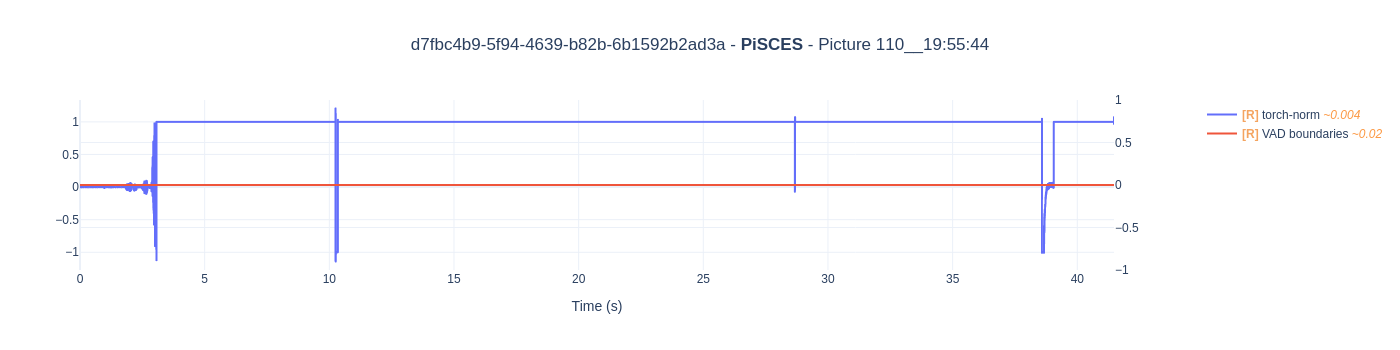

In [17]:
# Visualize a silent session
analyze_utterance(
    utterance=df_silent_sessions.iloc[5],
    # utterance=df_session[
    #     # (df_session.ID == "099ceb4d-28f3-4b1f-8f8e-16b439a882f1")
    #     (df_session.wav_duration_s <= 40)
    #     # & (df_session.time_str == "17:06:37")
    # ]
    # .sample(1)
    # .iloc[0],
    smile_lld=None,
    feat_cols=[],
    # utterance=df_session.sample(1).iloc[0],
    plot=True,
    audio=False,
    norm_audio=False,
    vad=True,
    noise_reduction=False,
    audio_begin_s=40,
    audio_end_s=50,
    show_corr=False,
    plot_type="png",
)


note: the VAD model does not detect any speech segments 🎉

age-sex: 25 - female		education: ho		device: headset
Playing from 0 to 40 seconds


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

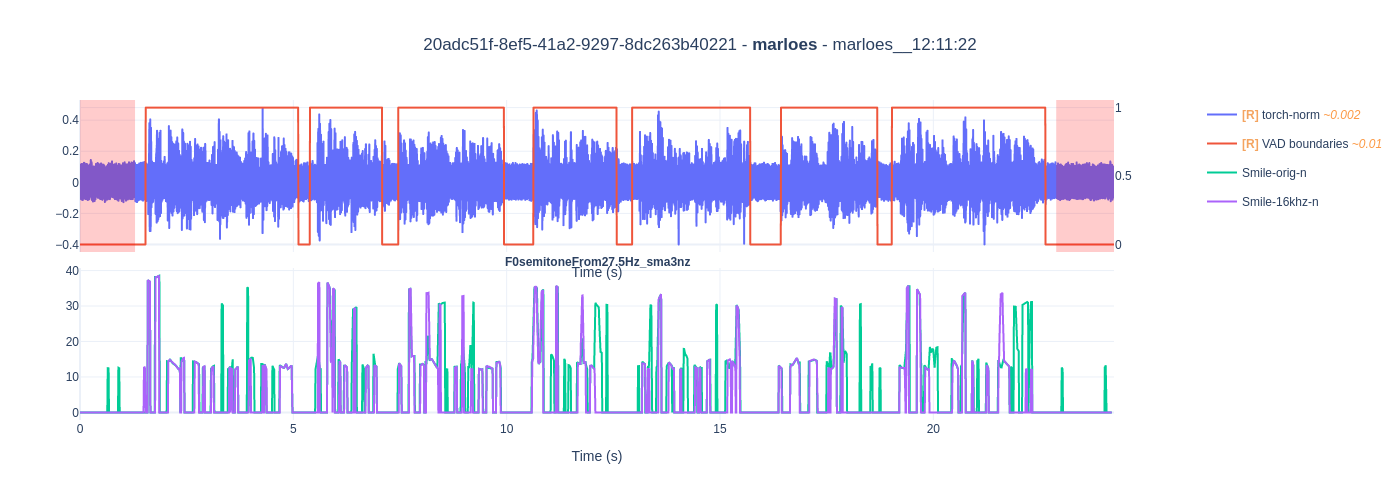

In [16]:
analyze_utterance(
    # A session with a high noise level
    utterance=df_session[
        (df_session.ID == "20adc51f-8ef5-41a2-9297-8dc263b40221")
        & (df_session.time_str == "12:11:22")
    ]
    .sample(1)
    .iloc[0],
    feat_cols=["F0semitoneFrom27.5Hz_sma3nz"],
    plot=True,
    audio=True,
    norm_audio=False,
    vad=True,
    noise_reduction=False,
    audio_begin_s=0,
    audio_end_s=40,
    show_corr=False,
    plot_type="png",
)


age-sex: 20 - male		education: so		device: pc-mic


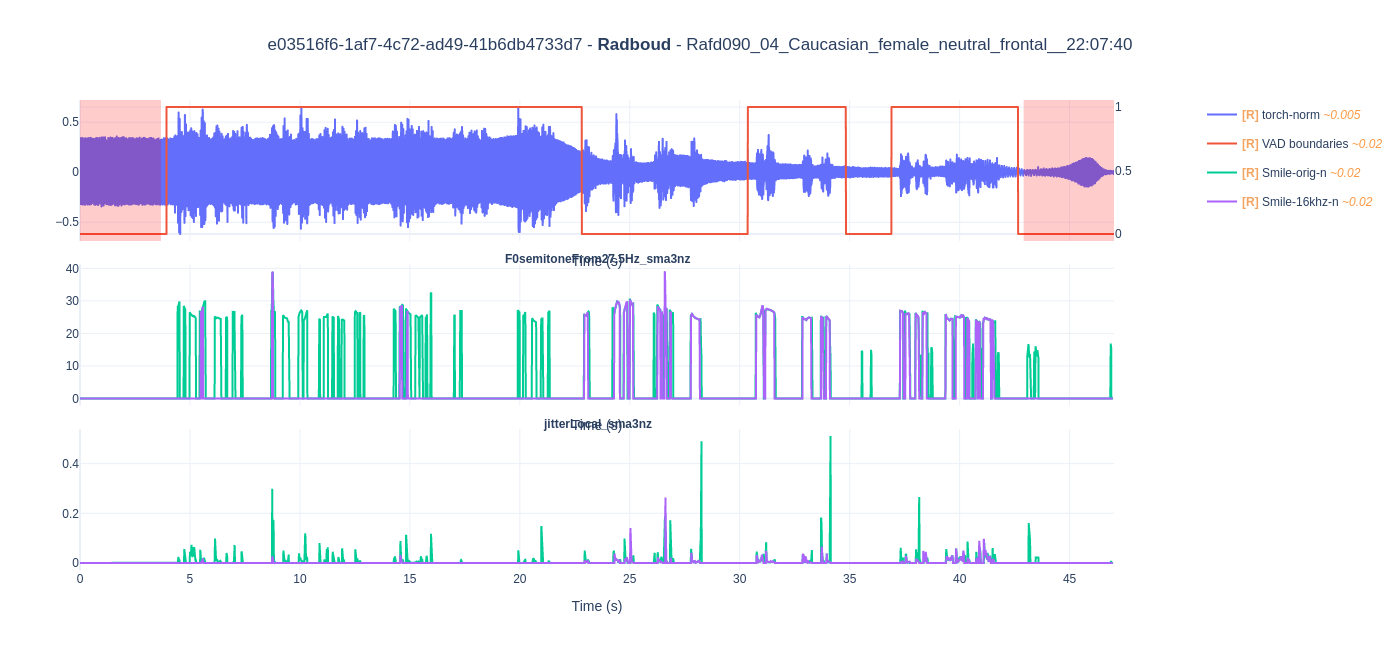

In [17]:
analyze_utterance(
    # Low quality session -> a lot of noise
    #   => opensmile cannot qualitatively extract features
    utterance=df_session[
        (df_session.ID == "e03516f6-1af7-4c72-ad49-41b6db4733d7")
        & (df_session.time_str == "22:07:40")
    ]
    .sample(1)
    .iloc[0],
    plot=True,
    audio=False,
    norm_audio=False,
    vad=True,
    noise_reduction=False,
    audio_begin_s=0,
    audio_end_s=40,
    show_corr=False,
    plot_type="png",
)
